In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sample_data.tst_model import TST

In [2]:
# Load dataset
df = pd.read_csv('/content/sample_data/BTCUSD5.csv', encoding='utf-8', sep=r';', engine='python', quotechar='"')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Date'] = pd.to_datetime(df['Date'].str.replace(r'^"|"$', '', regex=True).str.strip(), format='%Y.%m.%d', errors='coerce')

In [3]:

# Konversi kolom DateTime ke tipe datetime, lalu jadikan index
df.set_index('Date', inplace=True)

# Print bossku
print(df.head())
print(df.dtypes)

                      Open   High    Low  Close  Volume
Date                                                   
2004-06-11 07:15:00  384.0  384.1  384.0  384.0       3
2004-06-11 07:20:00  384.1  384.1  383.8  383.8       3
2004-06-11 07:25:00  383.8  384.3  383.8  384.3       6
2004-06-11 07:30:00  383.8  383.8  383.8  383.8       2
2004-06-11 07:35:00  383.8  384.3  383.6  383.8       6
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [4]:
# Jika ingin hanya mengambil kolom OHLC, bisa tambahkan volume dkk
ohlc = df[['Open','High','Low','Close']]
print(ohlc.head())

                      Open   High    Low  Close
Date                                           
2004-06-11 07:15:00  384.0  384.1  384.0  384.0
2004-06-11 07:20:00  384.1  384.1  383.8  383.8
2004-06-11 07:25:00  383.8  384.3  383.8  384.3
2004-06-11 07:30:00  383.8  383.8  383.8  383.8
2004-06-11 07:35:00  383.8  384.3  383.6  383.8


In [5]:
scaler = MinMaxScaler()
ohlc_scaled = scaler.fit_transform(ohlc)
print("Contoh hasil normalisasi:", ohlc_scaled[:3])

Contoh hasil normalisasi: [[0.00093059 0.00089783 0.00093156 0.00086647]
 [0.00096268 0.00089783 0.00086731 0.00080228]
 [0.00086641 0.00096196 0.00086731 0.00096274]]


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
def create_multistep_dataset(data, window_size=24, steps_ahead=5):
    X, y = [], []
    for i in range(len(data) - window_size - steps_ahead):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + steps_ahead])
    return np.array(X), np.array(y)

In [8]:
window_size = 24     # 1 jam (jika data pakai dataset usdchfm5)
steps_ahead = 5      # prediksi 5 bar ke depan 5x5menit = 25 menit

In [9]:
X, y = create_multistep_dataset(ohlc_scaled, window_size, steps_ahead)
print("X shape:", X.shape)  # (samples, 12, 4) 12 timestep dengan 4 fitur dataset OHLC gacor
print("y shape:", y.shape)  # (samples, 5, 4) 5 timestep prediksi ahead dengan4 fitur dataset OHLC gacor

X shape: (1397310, 24, 4)
y shape: (1397310, 5, 4)


In [10]:
# Split train-test tanpa shuffle (biar tetap urutan waktu)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (1117848, 24, 4)
y_train shape: (1117848, 5, 4)
X_test shape : (279462, 24, 4)
y_test shape : (279462, 5, 4)


In [12]:


class OHLCMultiStepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = OHLCMultiStepDataset(X_train, y_train)
test_dataset = OHLCMultiStepDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [13]:
# Ambil satu batch dari train_loader
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("Contoh X_batch[0]:\n", X_batch[0])
    print("Contoh y_batch[0]:\n", y_batch[0])
    break  # supaya hanya print 1 batch


X_batch shape: torch.Size([64, 24, 4])
y_batch shape: torch.Size([64, 5, 4])
Contoh X_batch[0]:
 tensor([[0.2757, 0.2754, 0.2757, 0.2754],
        [0.2755, 0.2753, 0.2756, 0.2753],
        [0.2754, 0.2752, 0.2757, 0.2754],
        [0.2754, 0.2752, 0.2756, 0.2754],
        [0.2754, 0.2752, 0.2757, 0.2754],
        [0.2755, 0.2752, 0.2757, 0.2754],
        [0.2754, 0.2752, 0.2757, 0.2753],
        [0.2752, 0.2750, 0.2754, 0.2752],
        [0.2752, 0.2750, 0.2754, 0.2751],
        [0.2751, 0.2749, 0.2753, 0.2750],
        [0.2750, 0.2750, 0.2753, 0.2751],
        [0.2752, 0.2750, 0.2754, 0.2752],
        [0.2753, 0.2751, 0.2755, 0.2753],
        [0.2753, 0.2750, 0.2754, 0.2751],
        [0.2751, 0.2749, 0.2754, 0.2751],
        [0.2751, 0.2749, 0.2754, 0.2750],
        [0.2751, 0.2749, 0.2754, 0.2751],
        [0.2752, 0.2750, 0.2754, 0.2751],
        [0.2752, 0.2751, 0.2754, 0.2753],
        [0.2753, 0.2751, 0.2755, 0.2752],
        [0.2752, 0.2750, 0.2755, 0.2752],
        [0.2752, 0.27

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TST(c_in=4, c_out=5*4, seq_len=24).to(device)  # pastikan output 20
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
print(model)


# TST(
#     c_in=4,
#     c_out=5*4,
#     seq_len=12,
#     d_model=128,           # Dimensi embedding / representasi
#     n_heads=8,             # Jumlah attention head
#     d_k=16, d_v=16,        # Dimensi masing-masing head (opsional)
#     n_layers=3,            # Jumlah encoder layer
#     d_ff=256,              # Ukuran hidden layer pada feedforward
#     dropout=0.1,           # Dropout seluruh network
#     fc_dropout=0.0,        # Dropout pada final dense layer
#     act="gelu",            # Fungsi aktivasi (bisa diganti 'relu')
#     y_range=None,          # Bisa pakai range sigmoid output (contoh: (0,1))
# )


TST(
  (W_P): Linear(in_features=4, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0-2): 3 x _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
          (attention): _ScaledDotProductAttention()
        )
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (batchnorm_attn): Sequential(
          (0): Transpose()
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Transpose()
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, i

In [15]:
# Model
model = TST(c_in=4, c_out=5*4, seq_len=24).to(device)


In [16]:
# Loss dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [17]:
# Config manual
epochs = 15
verbose = True

# Tracking loss
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).permute(0, 2, 1)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).view(-1, 5, 4)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device).permute(0, 2, 1)
            y_batch = y_batch.to(device)

            output = model(X_batch).view(-1, 5, 4)
            val_loss = criterion(output, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if verbose:
        print(f"Epoch {epoch:02d}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")


Epoch 01/15 - Train Loss: 0.000832 - Val Loss: 0.002134
Epoch 02/15 - Train Loss: 0.000273 - Val Loss: 0.000858
Epoch 03/15 - Train Loss: 0.000274 - Val Loss: 0.006366
Epoch 04/15 - Train Loss: 0.000215 - Val Loss: 0.008043
Epoch 05/15 - Train Loss: 0.000278 - Val Loss: 0.020164
Epoch 06/15 - Train Loss: 0.000283 - Val Loss: 0.002549
Epoch 07/15 - Train Loss: 0.000159 - Val Loss: 0.008973
Epoch 08/15 - Train Loss: 0.000150 - Val Loss: 0.025558
Epoch 09/15 - Train Loss: 0.000150 - Val Loss: 0.014076
Epoch 10/15 - Train Loss: 0.000160 - Val Loss: 0.014734
Epoch 11/15 - Train Loss: 0.000123 - Val Loss: 0.003075
Epoch 12/15 - Train Loss: 0.000291 - Val Loss: 0.010456
Epoch 13/15 - Train Loss: 0.000472 - Val Loss: 0.004848
Epoch 14/15 - Train Loss: 0.000089 - Val Loss: 0.003517
Epoch 15/15 - Train Loss: 0.000063 - Val Loss: 0.030122


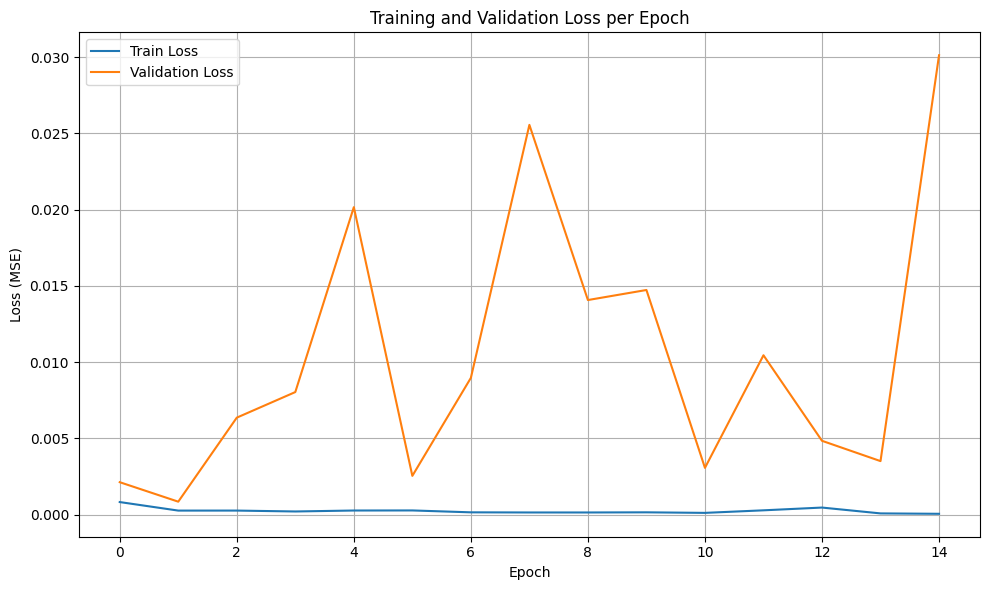

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
#Mclarenlu warna apa bos?
torch.save(model.state_dict(), "tst_GOLD5_24Timestep.pt")
print("Model saved to 'tst_ohlc_model.pt'")


Model saved to 'tst_ohlc_model.pt'


In [20]:
# Ambil satu sample dari test set
sample_input = X_test[0]  # shape: (12, 4)
sample_input = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0)  # (1, 12, 4)
sample_input = sample_input.permute(0, 2, 1).to(device)  # jadi (1, 4, 12)

# Load model dan jalankan prediksi
model.eval()
with torch.no_grad():
    output = model(sample_input).view(-1, 5, 4).cpu().numpy()  # (1, 5, 4) → (5, 4)

# Tampilkan hasil prediksi
print("Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):")
print(output[0])  # prediksi untuk langkah ke-1
print(output)     # semua 5 langkah

Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):
[[0.43869925 0.4384909  0.43890494 0.43859652]
 [0.43864295 0.4384942  0.4388628  0.43857133]
 [0.438617   0.43847996 0.4388969  0.43861824]
 [0.43866473 0.43859816 0.43896967 0.438779  ]
 [0.438816   0.43870825 0.4390081  0.4387719 ]]
[[[0.43869925 0.4384909  0.43890494 0.43859652]
  [0.43864295 0.4384942  0.4388628  0.43857133]
  [0.438617   0.43847996 0.4388969  0.43861824]
  [0.43866473 0.43859816 0.43896967 0.438779  ]
  [0.438816   0.43870825 0.4390081  0.4387719 ]]]
